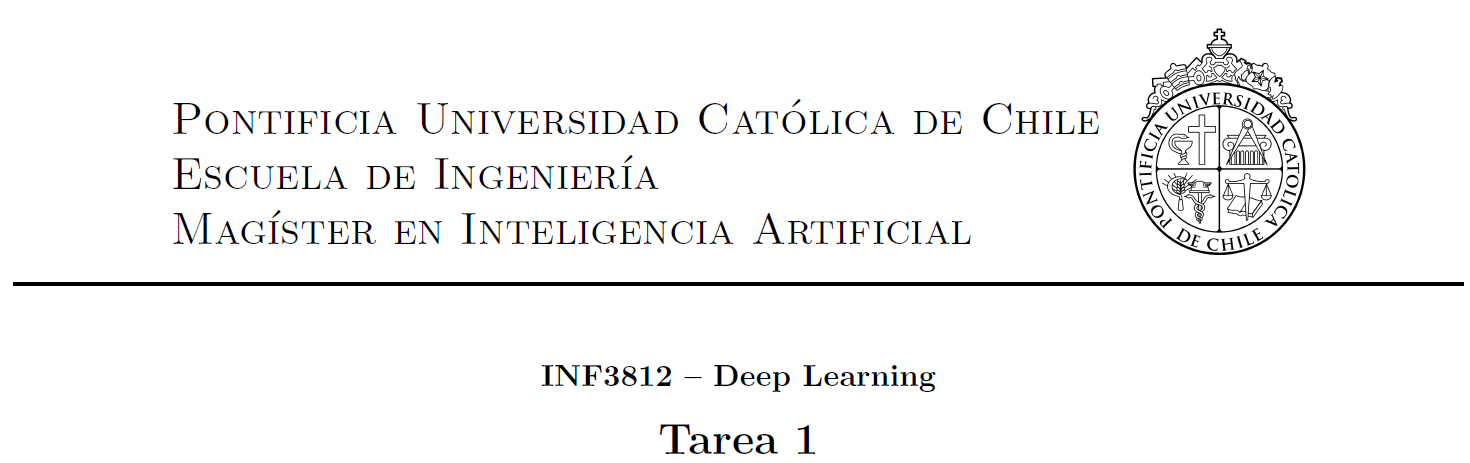

### Nicolás Castro 
### Marco Fura
### Marcos Reiman

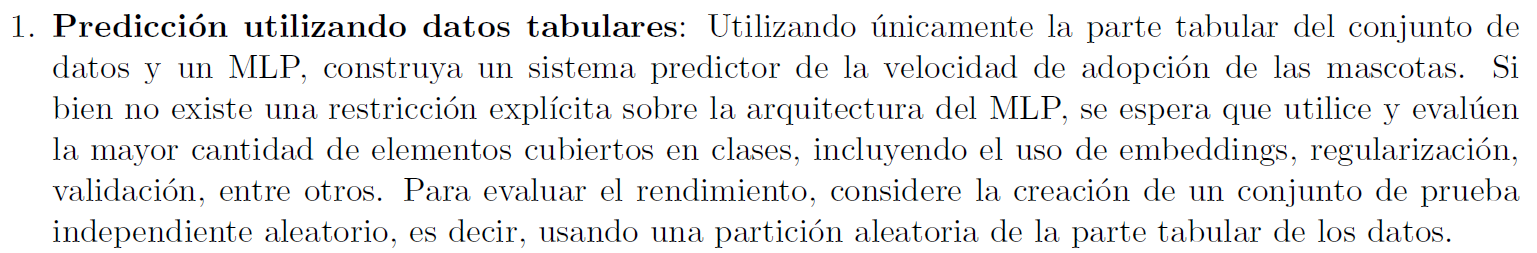

### Importación de Librerias

In [ ]:
# Importacion de Librerias

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from math import log2
from imblearn.over_sampling import SMOTE

### Carga de dataset y definición de variable objetivo

In [ ]:
# Cargar el dataset desde un archivo CSV
PATH = '../pet_adoption/data.csv'
dataset = pd.read_csv(PATH)

# Obtener los valores únicos de la columna 'AdoptionSpeed' (la variable objetivo)
np.unique(dataset['AdoptionSpeed'])

# Definir columnas que se deben remover, columnas categóricas para One-Hot Encoding y para embeddings, y columnas numéricas
columnas_a_remover = ['AdoptionSpeed', 'PetID', 'Name']
columnas_categoricas_ohe = ['Gender', 'Type', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health']
columnas_categoricas_emb = ["Breed1", "Breed2", "Color1", "Color2", "Color3", "State"]
columnas_numericas = ["Age", "Fee", "PhotoAmt"]

# Separar la variable objetivo (AdoptionSpeed) de las características
X = dataset.drop(columns=columnas_a_remover)
y = dataset['AdoptionSpeed']

# Imprimir el conteo de cada valor en la variable objetivo (para ver cuántas instancias hay de cada clase)
print(y[y == 0].count())
print(y[y == 1].count())
print(y[y == 2].count())
print(y[y == 3].count())
print(y[y == 4].count())

### División de Dataset / Definición de Pipeline

In [ ]:
# Dividir el dataset en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir un transformador de columnas para aplicar One-Hot Encoding a variables categóricas y escalar variables numéricas
column_transformer = ColumnTransformer(
    [("category_encoder", OneHotEncoder(dtype=int), columnas_categoricas_ohe),
     ('numeric_scaler', StandardScaler(), columnas_numericas)],
    remainder="passthrough",
)

# Definir un pipeline que aplica las transformaciones anteriores
pipeline = Pipeline(steps=[("preprocessor", column_transformer)])
pipeline.fit(X_train)

# Codificar las columnas para mantener un formato consistente
columnas_encoded = []
for col in columnas_categoricas_ohe:
    for val in np.unique(X_train[col]):
        columnas_encoded.append(f"{col}_{val}")

### Definición de Clases para LabelEncoder

In [ ]:
# Definir una clase personalizada para LabelEncoder que maneja valores desconocidos
class LabelEncoderWithUnknown(LabelEncoder):
    def __init__(self, unknown_label="unknown"):
        super().__init__()
        self.unknown_label = unknown_label

    def fit(self, y):
        y = list(y) + [self.unknown_label]
        super().fit(y)
        return self

    def transform(self, y):
        y = pd.Series(y).apply(lambda x: x if x in self.classes_ else self.unknown_label)
        return super().transform(y)

    def fit_transform(self, y):
        return self.fit(y).transform(y)


### Combinación de Encoders

In [ ]:
# Combinar y ajustar los codificadores de etiquetas para las columnas 'Breed', 'Color', y 'State'

all_breeds = pd.concat([X["Breed1"], X["Breed2"]])
all_colors = pd.concat([X["Color1"], X["Color2"], X["Color3"]])
label_encoder_breeds = LabelEncoderWithUnknown()
label_encoder_breeds.fit(all_breeds)

label_encoder_colors = LabelEncoderWithUnknown()
label_encoder_colors.fit(all_colors)

label_encoder_state = LabelEncoderWithUnknown()
label_encoder_state.fit(X["State"])

### Función de Preprocesamiento

In [ ]:
# Función para preprocesar las columnas aplicando las transformaciones definidas y el label encoding
def preprocesar_columnas(dataset, pipeline, label_encoders):
    dataset_encoded = pipeline.transform(dataset)
    dataset_encoded = pd.DataFrame(
        dataset_encoded,
        columns=columnas_encoded + columnas_numericas + columnas_categoricas_emb
    )
    dataset_encoded["Breed1"] = label_encoders['breeds'].transform(dataset_encoded["Breed1"])
    dataset_encoded["Breed2"] = label_encoders['breeds'].transform(dataset_encoded["Breed2"])
    dataset_encoded["Color1"] = label_encoders['colors'].transform(dataset_encoded["Color1"])
    dataset_encoded["Color2"] = label_encoders['colors'].transform(dataset_encoded["Color2"])
    dataset_encoded["Color3"] = label_encoders['colors'].transform(dataset_encoded["Color3"])
    dataset_encoded["State"] = label_encoders['states'].transform(dataset_encoded["State"])
    return dataset_encoded


### Diccionario de Encoders

In [ ]:
# Crear el diccionario de codificadores de etiquetas
label_encoders = {
    "breeds": label_encoder_breeds,
    "colors": label_encoder_colors,
    "states": label_encoder_state
}

# Preprocesar los datos de entrenamiento y visualizarlos
X_encoded = preprocesar_columnas(X_train, pipeline, label_encoders)
X_encoded.head()

# Definir las entradas del modelo para las variables categóricas y numéricas
input_raza_1 = Input(shape=(1,), name='Breed1')
input_raza_2 = Input(shape=(1,), name='Breed2')
input_color_1 = Input(shape=(1,), name='Color1')
input_color_2 = Input(shape=(1,), name='Color2')
input_color_3 = Input(shape=(1,), name='Color3')
input_state = Input(shape=(1,), name='State')

### Creación de Embeddings

In [ ]:
# Definir las dimensiones de salida de los embeddings para razas, colores y estados
output_dim_breed = int(log2(len(label_encoder_breeds.classes_)))
output_dim_color = int(log2(len(label_encoder_colors.classes_)))
output_dim_state = int(log2(len(label_encoder_state.classes_)))

# Crear embeddings para las columnas categóricas (razas, colores, estado)
embedding_breed_1 = Embedding(input_dim=len(label_encoder_breeds.classes_), output_dim=output_dim_breed)(input_raza_1)
embedding_breed_2 = Embedding(input_dim=len(label_encoder_breeds.classes_), output_dim=output_dim_breed)(input_raza_2)
embedding_color_1 = Embedding(input_dim=len(label_encoder_colors.classes_), output_dim=output_dim_color)(input_color_1)
embedding_color_2 = Embedding(input_dim=len(label_encoder_colors.classes_), output_dim=output_dim_color)(input_color_2)
embedding_color_3 = Embedding(input_dim=len(label_encoder_colors.classes_), output_dim=output_dim_color)(input_color_3)
embedding_state = Embedding(input_dim=len(label_encoder_state.classes_), output_dim=output_dim_state)(input_state)

# Aplanar las capas de embedding para concatenar en la red
flatten_breed_1 = Flatten()(embedding_breed_1)
flatten_breed_2 = Flatten()(embedding_breed_2)
flatten_color_1 = Flatten()(embedding_color_1)
flatten_color_2 = Flatten()(embedding_color_2)
flatten_color_3 = Flatten()(embedding_color_3)
flatten_state = Flatten()(embedding_state)

# Concatenar todas las entradas (embeddings y variables numéricas)
concatenated = Concatenate()([flatten_breed_1, flatten_breed_2, flatten_color_1, flatten_color_2, flatten_color_3, flatten_state])

### Construcción de Modelo

In [ ]:
# Construir el modelo con varias capas densas y activación 'ReLU'
x = Dense(512, activation="relu")(concatenated)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(5, activation="softmax")(x)

# Definir el modelo con entradas y salida
model = Model(inputs=[input_raza_1, input_raza_2, input_color_1, input_color_2, input_color_3, input_state], outputs=output)

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()

### Preprocesamiento y Balanceo

In [ ]:
# Preprocesar los datos de prueba
X_test_encoded = preprocesar_columnas(X_test, pipeline, label_encoders)

# Utilizar SMOTE para balancear el conjunto de datos en la clase '0'
X_encoded, y_train = SMOTE(sampling_strategy={0: 2000}).fit_resample(X_encoded, y_train)

### Diccionarios de Entradas

In [ ]:
# Definir los diccionarios de entradas para el modelo (tanto para entrenamiento como para prueba)
X_train_dict = {
    "Breed1": X_encoded["Breed1"],
    "Breed2": X_encoded["Breed2"],
    "Color1": X_encoded["Color1"],
    "Color2": X_encoded["Color2"],
    "Color3": X_encoded["Color3"],
    "State": X_encoded["State"]
}

X_test_dict = {
    "Breed1": X_test_encoded["Breed1"],
    "Breed2": X_test_encoded["Breed2"],
    "Color1": X_test_encoded["Color1"],
    "Color2": X_test_encoded["Color2"],
    "Color3": X_test_encoded["Color3"],
    "State": X_test_encoded["State"]
}

### Definiciones para la Regularización

In [ ]:
# Definir las callbacks para detener temprano el entrenamiento y reducir el learning rate si es necesario
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1, mode="min", min_lr=0.001)

### Entrenamiento con Preprocesamiento

In [ ]:
# Entrenar el modelo utilizando los datos preprocesados
history = model.fit(X_train_dict, y_train, epochs=50, validation_data=(X_test_dict, y_test), callbacks=[reduce_lr], verbose=1)

### Prediccciones con Datos de Prueba

In [ ]:
# Realizar predicciones sobre los datos de prueba
prediciones = model.predict(X_test_dict)
predicciones_clase = np.argmax(prediciones, axis=1)

### Análisis Matriz de Confusión

In [ ]:
# Generar una matriz de confusión para evaluar el rendimiento del modelo
matriz_confusion = confusion_matrix(y_test, predicciones_clase)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion)
disp.plot(cmap=plt.cm.Blues)
plt.show()

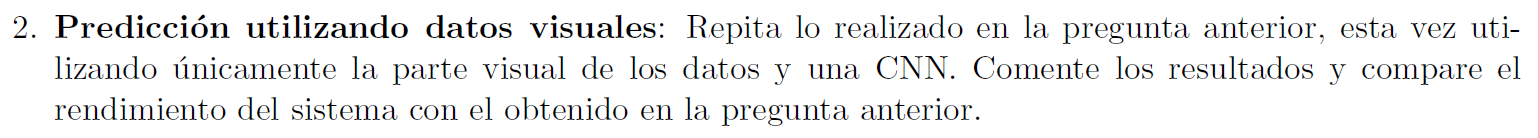

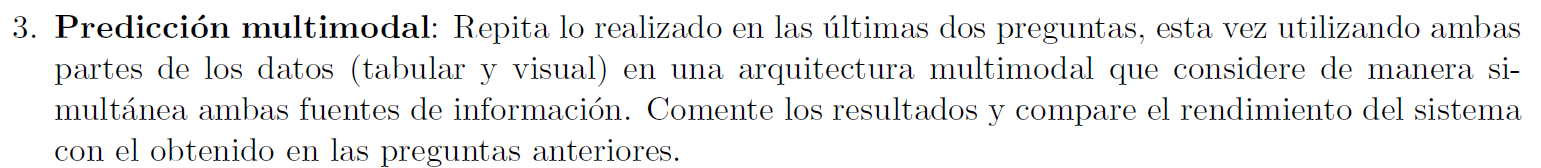